In [633]:
# The code was removed by Watson Studio for sharing.

#  Falcon 9 First Stage Re-Launch Prediction.

Import Libraries.

In [634]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Function for confusion matrix plotting.

In [635]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not re-used', 're-used']); ax.yaxis.set_ticklabels(['not re-used', 're-used'])

Import csv file

In [636]:
df = pd.read_csv(project.get_file('data_wrangling.csv'))
print(df.shape)
df.head()

(133, 22)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,PayloadName,Customer,Outcome,Flights,GridFins,...,LandingPad,Block,Serial,Status,ReusedCount,LaunchSite,Longitude,Latitude,Block_Version,Class
0,1,2010-06-04,Falcon 9,7457.0,LEO,Dragon Qualification Unit,SpaceX,None None,1,False,...,NaN,1.0,B0003,expended,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
1,2,2012-05-22,Falcon 9,525.0,LEO,COTS Demo Flight 2,NASA(COTS),None None,1,False,...,NaN,1.0,B0005,lost,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
2,3,2013-03-01,Falcon 9,677.0,ISS,CRS-2,NASA (CRS),None None,1,False,...,NaN,1.0,B0007,lost,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
3,4,2013-09-29,Falcon 9,500.0,PO,CASSIOPE,MDA,False Ocean,1,False,...,NaN,1.0,B1003,lost,0,VAFB SLC 4E,-120.610829,34.632093,v1.0,0
4,5,2013-12-03,Falcon 9,3170.0,GTO,SES-8,SES,None None,1,False,...,NaN,1.0,B1004,lost,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0


## Data Analysis.

Count of sucessfull/failed landing ratio.

In [637]:
df['Class'].value_counts()

1    102
0     31
Name: Class, dtype: int64

The percentage of flights in which the first stage booster was reused.

In [638]:
df['Reused'].value_counts(normalize=True)

True     0.56391
False    0.43609
Name: Reused, dtype: float64

Block Version, Boosters serials, current status, and count of flights for each booster.

In [639]:
count_launch = df.groupby(['Block','Serial','Status'])['Flights'].count().reset_index(name='Count')
reused_count = count_launch[count_launch['Count'] >= 2]
reused_count.tail(10)

,Block,Serial,Status,Count
44,5.0,B1049,active,10
46,5.0,B1051,active,10
49,5.0,B1056,lost,4
50,5.0,B1058,active,10
51,5.0,B1059,lost,6
52,5.0,B1060,active,10
53,5.0,B1061,active,6
54,5.0,B1062,active,4
55,5.0,B1063,active,3
56,5.0,B1067,active,3


All currently active booster and the count of flights.

In [640]:
active_boosters = count_launch[count_launch['Status'] == 'active']
active_boosters

,Block,Serial,Status,Count
44,5.0,B1049,active,10
46,5.0,B1051,active,10
47,5.0,B1052,active,1
50,5.0,B1058,active,10
52,5.0,B1060,active,10
53,5.0,B1061,active,6
54,5.0,B1062,active,4
55,5.0,B1063,active,3
56,5.0,B1067,active,3
57,5.0,B1069,active,1


DataFRame column names.

In [641]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'PayloadName', 'Customer', 'Outcome', 'Flights', 'GridFins', 'Reused',
       'Legs', 'LandingPad', 'Block', 'Serial', 'Status', 'ReusedCount',
       'LaunchSite', 'Longitude', 'Latitude', 'Block_Version', 'Class'],
      dtype='object')

## Feature Engineering.

Create new 'StatClass' column from the 'Status' column, and convert categorical variables into integers.

In [642]:
df['StatClass'] = df['Status'].replace({'active': 1})

df.loc[df['StatClass']!=1, 'StatClass'] = 0

Filter DataFrame with only the columns needed for the model. In order to prevent overfitting I'll be dropping some features with significant weight. This includes 'LaunchCount', 'Serial', 'Block'.

In [643]:
feature_df = df[['FlightNumber','PayloadMass','Orbit','Outcome', 'Flights','GridFins','Legs','LandingPad','LaunchSite']]
feature_df.head()

,FlightNumber,PayloadMass,Orbit,Outcome,Flights,GridFins,Legs,LandingPad,LaunchSite
0,1,7457.0,LEO,None None,1,False,False,NaN,CCSFS SLC 40
1,2,525.0,LEO,None None,1,False,False,NaN,CCSFS SLC 40
2,3,677.0,ISS,None None,1,False,False,NaN,CCSFS SLC 40
3,4,500.0,PO,False Ocean,1,False,False,NaN,VAFB SLC 4E
4,5,3170.0,GTO,None None,1,False,False,NaN,CCSFS SLC 40


Perform one_hot encoding using get_dummies.

In [644]:
one_hot = pd.get_dummies(feature_df, columns=['Orbit', 'Outcome', 'LandingPad', 'LaunchSite'])
one_hot = one_hot.astype(float)
one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Legs,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Outcome_True RTLS,LandingPad_ASOG,LandingPad_JRTI,LandingPad_JRTI-1,LandingPad_LZ-1,LandingPad_LZ-4,LandingPad_OCISLY,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E
0,1.0,7457.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,525.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,677.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,3170.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Create an object using StandardScaler.

In [645]:
transform = preprocessing.StandardScaler()

Fit transform the one_hot DataFrame and save ass the x variable for model training.

In [646]:
x = transform.fit(one_hot).transform(one_hot)

Save the 'StatClass' column as an array, converted to float and save as the target variable.

In [647]:
y = np.asarray(df['StatClass'].astype(float))

## Logistic Regression Model.

Split the DataFrame for training.

In [648]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=15, stratify=y)#random_state:2,5,6,14,15

Create parameters, create a lr object, create GridSearchObjectCV, and fit the data.

In [649]:
params_lr = {'solver':['lbfgs','newton-cg','liblinear'],'penalty':['l2'], 'C':[.0001,.001,.01,.1,1]}

lr = LogisticRegression(random_state=1)

lr_grid = GridSearchCV(lr, params_lr, scoring='f1', cv=10)

lr_grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear']},
             scoring='f1')

Print the best parameters.

In [650]:
print('The best estimator:',lr_grid.best_params_)

The best estimator: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


Save the GridSearchCV score.

In [651]:
lr_test_score = lr_grid.score(x_test,y_test)

Predict using the test data and  plot the confusion matrix.

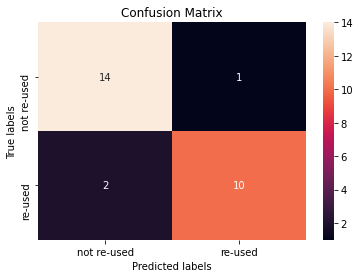

In [652]:
lr_hat = lr_grid.predict(x_test)
plot_confusion_matrix(y_test,lr_hat)

Predict the probability and save the log loss score.

In [653]:
lr_proba = lr_grid.predict_proba(x_test)

lr_log_loss = metrics.log_loss(y_test,lr_proba)

In [654]:
print(lr_grid.score(x_test,y_test))
print(metrics.log_loss(y_test,lr_proba))

0.8695652173913043
0.19581400200490395


## SVC Model.

Split the DataFrame for training.

In [655]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=1, stratify=y)#random_state:1,6

Create parameters, create a svc object, create GridSearchObjectCV, and fit the data.

In [656]:
params_svc = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C': np.logspace(0,3,5), 'gamma':np.logspace(-3,3,5)}

svc = SVC(probability=True, random_state=1)

svc_grid = GridSearchCV(svc, params_svc, scoring='f1', cv=10)

svc_grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1),
             param_grid={'C': array([   1.        ,    5.62341325,   31.6227766 ,  177.827941  ,
       1000.        ]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='f1')

Print the best parameters.

In [657]:
print('Best parameters:', svc_grid.best_params_)

Best parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}


Save the GridSearchCV score.

In [658]:
svc_test_score = svc_grid.score(x_test,y_test)

Predict using the test data and plot the confusion matrix.

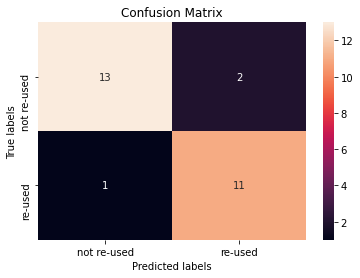

In [659]:
svc_hat = svc_grid.predict(x_test)
plot_confusion_matrix(y_test,svc_hat)

Predict the probability and save the log loss score.

In [660]:
svc_proba = svc_grid.predict_proba(x_test)

svc_log_loss = metrics.log_loss(y_test, svc_proba)

In [661]:
print(svc_grid.score(x_test,y_test))
print(metrics.log_loss(y_test, svc_proba))

0.8799999999999999
0.291694244013763


## Decision Tree Classifier Model.

Split the DataFrame for training.

In [823]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=10, stratify=y)#random_state:10

Create parameters, create a tree object, create GridSearchObjectCV, and fit the data.

In [824]:
params_tree = {'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':[2*n for n in range(2,10)], 'min_samples_split': range(2,10), 'max_features':['auto', 'sqrt', 'log2']}

tree = DecisionTreeClassifier(random_state=1)

tree_grid = GridSearchCV(tree, params_tree, scoring='f1', cv=10)

tree_grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']},
             scoring='f1')

Print the best parameters.

In [825]:
print('Best parameters:',tree_grid.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 9, 'splitter': 'best'}


Save the GridSearchCV score.

In [826]:
tree_test_score = tree_grid.score(x_test,y_test)

Predict using the test data and plot the confusion matrix.

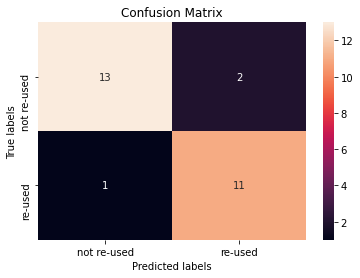

In [827]:
tree_hat = tree_grid.predict(x_test)
plot_confusion_matrix(y_test,tree_hat)

Predict the probability and save the log loss score.

In [828]:
tree_proba = tree_grid.predict_proba(x_test)

tree_log_loss = metrics.log_loss(y_test, tree_proba)

In [829]:
print(tree_grid.score(x_test,y_test))
print(metrics.log_loss(y_test, tree_proba))

0.8799999999999999
0.276094545807793


## KNearest Neighbor Classifier Model.

Split the DataFrame for training.

In [915]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=9, stratify=y)#random_state:1,3,6,9,10

Create parameters, create a tree object, create GridSearchObjectCV, and fit the data.

In [916]:
params_knn = {'n_neighbors': [6], 'weights':['uniform','distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': range(2,10)}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, params_knn, scoring='f1', cv=10)

knn_grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [6], 'p': range(2, 10),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

Print the best parameters.

In [917]:
print('Best parameters:', knn_grid.best_params_)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 6, 'p': 4, 'weights': 'distance'}


Save the GridSearchCV score.

In [918]:
knn_test_score = knn_grid.score(x_test,y_test)

Predict using the test data and plot the confusion matrix.

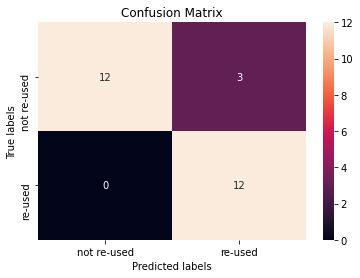

In [919]:
knn_hat = knn_grid.predict(x_test)
plot_confusion_matrix(y_test,knn_hat)

Predict the probability and save the log loss score.

In [920]:
knn_proba = knn_grid.predict_proba(x_test)

knn_log_loss = metrics.log_loss(y_test, knn_proba)

In [921]:
print(knn_grid.score(x_test,y_test))
print(metrics.log_loss(y_test, knn_proba))

0.888888888888889
0.2600716712923132


## Model Evaluation.

Create function for cross_val_score

In [924]:
def cross_val_function(x, y, n_split):
    
    global df
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import KFold, cross_val_score
    
    
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('SVC', SVC()))
    models.append(('TREE', DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    

    main_list = []
    
    for name, model in models:
        
        sub_list = []
       
        kfold = KFold(n_splits=int(n_split))
        cv_results = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
        sub_list.append(name)
        sub_list.append(cv_results.mean().round(decimals=2))
        sub_list.append(cv_results.std().round(decimals=2))
        
        main_list.append(sub_list)
        
     
    df = pd.DataFrame(main_list)
    
    df.columns = ['model', 'cv_score', 'cv_std']
    
    return(df)

Call the cross_val_score function.

In [925]:
cross_val_function(x, y, 10)

,model,cv_score,cv_std
0,LR,0.91,0.14
1,SVC,0.90,0.11
2,TREE,0.83,0.20
3,KNN,0.87,0.15


Create list and append score results from the models.

In [926]:
lr_list = ['LR']
svc_list = ['SVC']
tree_list = ['TREE']
knn_list = ['KNN']
metod_list = []

lr_list.append(lr_test_score)
lr_list.append(lr_log_loss)

svc_list.append(svc_test_score)
svc_list.append(svc_log_loss)

tree_list.append(tree_test_score)
tree_list.append(tree_log_loss)

knn_list.append(knn_test_score)
knn_list.append(knn_log_loss)

metod_list.append(lr_list)
metod_list.append(svc_list)
metod_list.append(tree_list)
metod_list.append(knn_list)

Create a DataFrame from the lists and the score results.

In [927]:
metod_df = pd.DataFrame(metod_list).round(decimals=2)
metod_df.columns = ['Model', 'Test_score', 'LogLoss']
metod_df

,Model,Test_score,LogLoss
0,LR,0.87,0.20
1,SVC,0.88,0.29
2,TREE,0.88,0.28
3,KNN,0.89,0.26


Plot a bar plot using matplotlib with the values from metod_df.

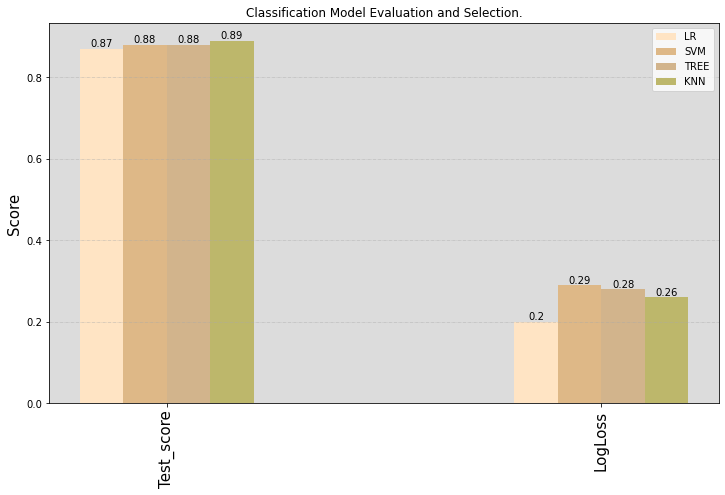

In [928]:
labels =  metod_df.drop(['Model'], axis=1).columns.tolist()
lr_bar = metod_df.iloc[0,1:].tolist()
svm_bar = metod_df.iloc[1,1:].tolist()
tree_bar = metod_df.iloc[2,1:].tolist()
knn_bar = metod_df.iloc[3,1:].tolist()

label_loc = np.arange(len(labels))
width = .10

xtick_loc = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12,7))
lr_label = ax.bar(label_loc - 2*width +.05, lr_bar, width, label='LR', color='bisque')
svm_label = ax.bar(label_loc - width +.05, svm_bar, width, label='SVM', color='burlywood')
tree_label = ax.bar(label_loc +.05, tree_bar, width, label='TREE', color='tan')
knn_label = ax.bar(label_loc + width + .05, knn_bar, width, label='KNN', color= 'darkkhaki')


ax.set_xticks(xtick_loc)
ax.set_xticklabels(labels, rotation=90, fontsize=15)
ax.set_title('Classification Model Evaluation and Selection.')
ax.grid(b=True, color='darkgray', linestyle='-.', linewidth=.5, alpha=.8, axis='y')
ax.set_ylabel('Score', fontsize=15)
ax.set_facecolor('gainsboro')
ax.legend()

list1 = []

for i, v in metod_df.iterrows():
    list1.append(v[1])
    list1.append(v[2])
    
rects = ax.patches

annot = [list1[index] for index in range(len(list1))]

for rects, annot in zip(rects, annot):
    height = rects.get_height()
    ax.text(rects.get_x() + rects.get_width() / 2, height, annot, ha='center', va='bottom')

plt.show()